In [28]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('api_metod_40k_15_fields.csv')

In [7]:
df.head()

,Title,id,price,author,publisher,pub_year,s_tile,edition_num,description,availabe,sale_date,short_pub,num_of_author,width,height
0,Learning Go,211190367,71.990000,Jon Bodner,O'Reilly Media,2024,NaN,(2nd ed.),Go has rapidly become the preferred language f...,True,2024-01-10T00:00:00,Jan 2024,1,97,150
1,Tidy First?,211127822,42.990000,Kent Beck,O'Reilly Media,2023,NaN,NaN,Tidying up messy software is a must. And that ...,True,2023-10-17T00:00:00,Oct 2023,1,97,150
2,"Hands-On Machine Learning with Scikit-Learn, K...",210681725,96.990000,Aurélien Géron,O'Reilly Media,2022,NaN,(3rd ed.),"Through a recent series of breakthroughs, deep...",True,2022-10-04T00:00:00,Oct 2022,1,97,150
3,Designing Data-Intensive Applications,95729334,67.990000,Martin Kleppmann,O'Reilly Media,2017,"The Big Ideas Behind Reliable, Scalable, and M...",NaN,Data is at the center of many challenges in sy...,True,2017-03-16T00:00:00,Mar 2017,1,97,150
4,Exam Ref MS-102 Microsoft 365 Administrator,210964419,53.862731,Orin Thomas,Pearson Education,2023,NaN,NaN,Prepare for Microsoft Exam MS-102 and help dem...,True,2023-10-18T00:00:00,Oct 2023,1,97,150


In [9]:
df.dropna(subset=['description'], inplace=True)

In [10]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=100, stop_words='english')

In [11]:
# Fit and transform the 'description' column
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])

In [12]:
# Get feature names to use as keywords
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [13]:
# Extract the scores for the keywords
tfidf_scores = tfidf_matrix.sum(axis=0).A1
tfidf_ranking = list(zip(tfidf_feature_names, tfidf_scores))

In [14]:
# Sort the keywords by their TF-IDF score
sorted_tfidf_ranking = sorted(tfidf_ranking, key=lambda x: x[1], reverse=True)

In [15]:
# Print the top 10 keywords
print("Top 10 TF-IDF Keywords:")
for term, score in sorted_tfidf_ranking[:10]:
    print(f"{term}: {score}")

Top 10 TF-IDF Keywords:
book: 3112.422014009895
data: 1626.0465207906939
conference: 1606.0671767852527
international: 1446.4271796616238
held: 1425.8392914394512
papers: 1404.3255701598137
systems: 1379.8774718326533
applications: 1340.6979331841253
proceedings: 1307.111547176416
guide: 1303.398132975868


In [16]:
# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")  # make sure to download this model with spacy download en_core_web_sm

In [17]:
# Function to extract entities as keywords using SpaCy
def spacy_extract_keywords(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]


In [18]:
# Apply the function to the 'description' column
df['spacy_keywords'] = df['description'].apply(spacy_extract_keywords)

In [19]:
# Print some of the extracted keywords
print("Extracted Keywords using SpaCy:")
print(df['spacy_keywords'].head())

Extracted Keywords using SpaCy:
0                                      [Go]
1          [Kent Beck, Extreme Programming]
2                                        []
3                            [today, NoSQL]
4    [Microsoft Exam, Microsoft, Microsoft]
Name: spacy_keywords, dtype: object


In [20]:
# Convert the list of keywords into a string as CountVectorizer expects string input
df['keywords_str'] = df['spacy_keywords'].apply(lambda x: ' '.join(x))

In [24]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['keywords_str'])
X_norm = normalize(X)  # Normalizing the data

In [25]:
# Elbow Method and Silhouette Score evaluation for K-Means and MiniBatch K-Means
range_n_clusters = range(2, 21)  # example range, could be adjusted as needed
sse = []
silhouette_scores_kmeans = []
silhouette_scores_minibatch = []

In [26]:
for n_clusters in range_n_clusters:
    # K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_norm)
    sse.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center
    
    # MiniBatch K-Means Clustering
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=100)
    minibatch_kmeans_labels = minibatch_kmeans.fit_predict(X_norm)
    
    # Silhouette Score for K-Means
    silhouette_avg_kmeans = silhouette_score(X_norm, kmeans_labels)
    silhouette_scores_kmeans.append(silhouette_avg_kmeans)
    
    # Silhouette Score for MiniBatch K-Means
    silhouette_avg_minibatch = silhouette_score(X_norm, minibatch_kmeans_labels)
    silhouette_scores_minibatch.append(silhouette_avg_minibatch)
    
    print(f"For n_clusters = {n_clusters}, K-Means Silhouette Score: {silhouette_avg_kmeans}")
    print(f"For n_clusters = {n_clusters}, MiniBatch K-Means Silhouette Score: {silhouette_avg_minibatch}")

/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 2, K-Means Silhouette Score: 0.09524728263566047
For n_clusters = 2, MiniBatch K-Means Silhouette Score: 0.09534670556431067


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 3, K-Means Silhouette Score: 0.10139785328226428
For n_clusters = 3, MiniBatch K-Means Silhouette Score: 0.09748659208337868


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 4, K-Means Silhouette Score: 0.10668764871481025
For n_clusters = 4, MiniBatch K-Means Silhouette Score: 0.0823695174389213


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 5, K-Means Silhouette Score: 0.11193941815326867
For n_clusters = 5, MiniBatch K-Means Silhouette Score: 0.10087991735595804


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 6, K-Means Silhouette Score: 0.11226350003723118
For n_clusters = 6, MiniBatch K-Means Silhouette Score: 0.1032133011868338


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 7, K-Means Silhouette Score: 0.1115492915879489
For n_clusters = 7, MiniBatch K-Means Silhouette Score: 0.10805313731157688


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 8, K-Means Silhouette Score: 0.11335626531460175
For n_clusters = 8, MiniBatch K-Means Silhouette Score: 0.10088067029249122


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 9, K-Means Silhouette Score: 0.1192027642187605
For n_clusters = 9, MiniBatch K-Means Silhouette Score: 0.07510303326494731


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 10, K-Means Silhouette Score: 0.11898853803519781
For n_clusters = 10, MiniBatch K-Means Silhouette Score: 0.08304340192283598


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 11, K-Means Silhouette Score: 0.12161284781082483
For n_clusters = 11, MiniBatch K-Means Silhouette Score: 0.1059880460320886


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 12, K-Means Silhouette Score: 0.12078329206890258
For n_clusters = 12, MiniBatch K-Means Silhouette Score: 0.08364376911782986


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 13, K-Means Silhouette Score: 0.11859170999141175
For n_clusters = 13, MiniBatch K-Means Silhouette Score: 0.08697978745948445


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 14, K-Means Silhouette Score: 0.12683240839963725
For n_clusters = 14, MiniBatch K-Means Silhouette Score: 0.07853775988435387


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 15, K-Means Silhouette Score: 0.12420270642933894
For n_clusters = 15, MiniBatch K-Means Silhouette Score: 0.11778808357842192


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 16, K-Means Silhouette Score: 0.13332481541663038
For n_clusters = 16, MiniBatch K-Means Silhouette Score: 0.10391217290773735


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 17, K-Means Silhouette Score: 0.13042660303098813
For n_clusters = 17, MiniBatch K-Means Silhouette Score: 0.10878886670116324


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 18, K-Means Silhouette Score: 0.1289038481285191
For n_clusters = 18, MiniBatch K-Means Silhouette Score: 0.12549921851287346


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 19, K-Means Silhouette Score: 0.13723472123234007
For n_clusters = 19, MiniBatch K-Means Silhouette Score: 0.12172468725613594


/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


For n_clusters = 20, K-Means Silhouette Score: 0.13452409892449763
For n_clusters = 20, MiniBatch K-Means Silhouette Score: 0.11130175444934891


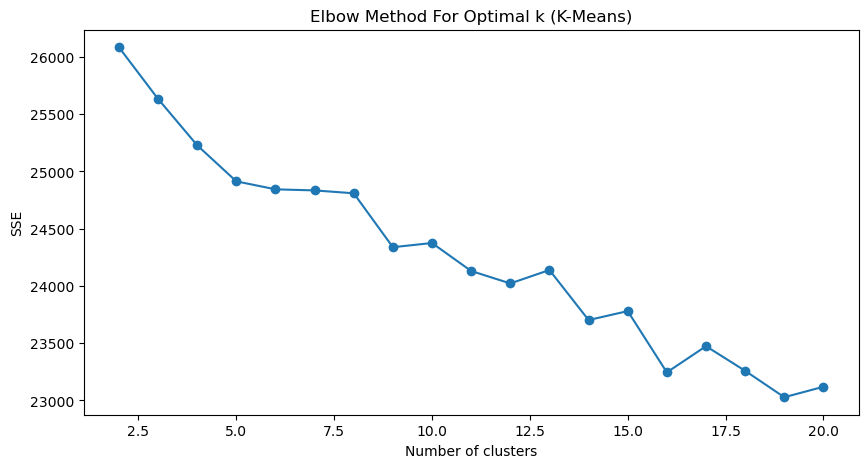

In [29]:
# Plot SSE for Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, sse, marker='o')
plt.title('Elbow Method For Optimal k (K-Means)')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

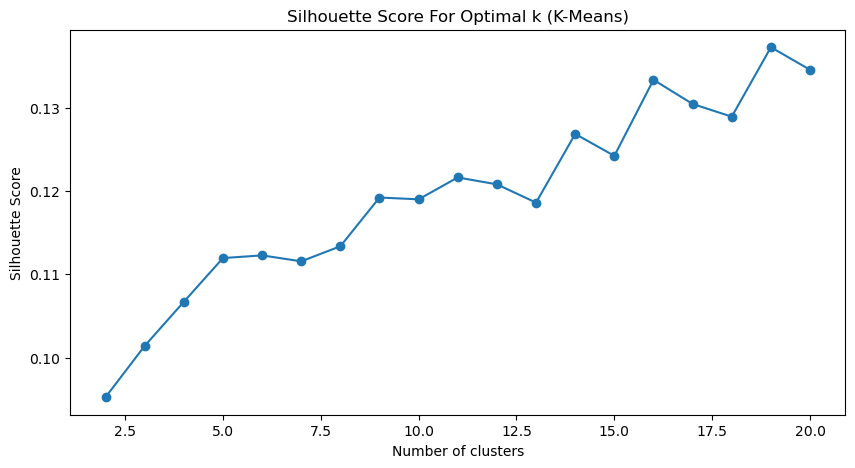

In [31]:
# Plot Silhouette Scores for K-Means
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores_kmeans, marker='o')
plt.title('Silhouette Score For Optimal k (K-Means)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

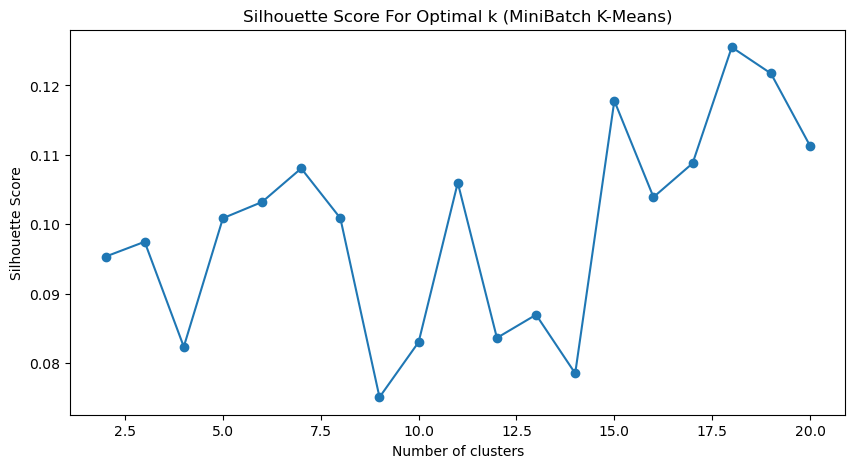

In [30]:
# Plot Silhouette Scores for MiniBatch K-Means
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores_minibatch, marker='o')
plt.title('Silhouette Score For Optimal k (MiniBatch K-Means)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [32]:
# Choose the optimal number of clusters based on the highest silhouette score
optimal_n_clusters_kmeans = range_n_clusters[silhouette_scores_kmeans.index(max(silhouette_scores_kmeans))]
optimal_n_clusters_minibatch = range_n_clusters[silhouette_scores_minibatch.index(max(silhouette_scores_minibatch))]

print(f"The optimal number of clusters for K-Means is {optimal_n_clusters_kmeans}.")
print(f"The optimal number of clusters for MiniBatch K-Means is {optimal_n_clusters_minibatch}.")

The optimal number of clusters for K-Means is 19.
The optimal number of clusters for MiniBatch K-Means is 18.


In [34]:
# K-Means Clustering
kmeans = KMeans(n_clusters=18, random_state=42)
kmeans_labels = kmeans.fit_predict(X_norm)
df['Cluster_KMeans'] = kmeans_labels

/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [35]:
# MiniBatch K-Means Clustering
minibatch_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42)
minibatch_kmeans_labels = minibatch_kmeans.fit_predict(X_norm)
df['Cluster_MiniBatchKMeans'] = minibatch_kmeans_labels

/Users/prashanta/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [36]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Parameters might need tuning
dbscan_labels = dbscan.fit_predict(X_norm)
df['Cluster_DBSCAN'] = dbscan_labels

In [38]:
# Evaluate clustering performance using silhouette scores
# (Note: silhouette score can't be calculated for DBSCAN if there's only one cluster or noise)
kmeans_silhouette = silhouette_score(X_norm, kmeans_labels)
minibatch_silhouette = silhouette_score(X_norm, minibatch_kmeans_labels)

print(f"K-Means Silhouette Score: {kmeans_silhouette}")
print(f"Minibatch-KMeans Silhouette Score: {minibatch_silhouette}")

K-Means Silhouette Score: 0.1289038481285191
Minibatch-KMeans Silhouette Score: 0.07884936847006999


In [39]:
df.head()

,Title,id,price,author,publisher,pub_year,s_tile,edition_num,description,availabe,sale_date,short_pub,num_of_author,width,height,spacy_keywords,keywords_str,Cluster_KMeans,Cluster_MiniBatchKMeans,Cluster_DBSCAN
0,Learning Go,211190367,71.990000,Jon Bodner,O'Reilly Media,2024,NaN,(2nd ed.),Go has rapidly become the preferred language f...,True,2024-01-10T00:00:00,Jan 2024,1,97,150,[Go],Go,1,4,-1
1,Tidy First?,211127822,42.990000,Kent Beck,O'Reilly Media,2023,NaN,NaN,Tidying up messy software is a must. And that ...,True,2023-10-17T00:00:00,Oct 2023,1,97,150,"[Kent Beck, Extreme Programming]",Kent Beck Extreme Programming,1,4,-1
2,"Hands-On Machine Learning with Scikit-Learn, K...",210681725,96.990000,Aurélien Géron,O'Reilly Media,2022,NaN,(3rd ed.),"Through a recent series of breakthroughs, deep...",True,2022-10-04T00:00:00,Oct 2022,1,97,150,[],,1,4,0
3,Designing Data-Intensive Applications,95729334,67.990000,Martin Kleppmann,O'Reilly Media,2017,"The Big Ideas Behind Reliable, Scalable, and M...",NaN,Data is at the center of many challenges in sy...,True,2017-03-16T00:00:00,Mar 2017,1,97,150,"[today, NoSQL]",today NoSQL,3,3,-1
4,Exam Ref MS-102 Microsoft 365 Administrator,210964419,53.862731,Orin Thomas,Pearson Education,2023,NaN,NaN,Prepare for Microsoft Exam MS-102 and help dem...,True,2023-10-18T00:00:00,Oct 2023,1,97,150,"[Microsoft Exam, Microsoft, Microsoft]",Microsoft Exam Microsoft Microsoft,13,3,1


In [45]:
df['Cluster_DBSCAN'].value_counts()

Cluster_DBSCAN
-1      22250
 0       6698
 16       532
 1        288
 32       280
        ...  
 191        5
 195        5
 249        5
 17         5
 215        5
Name: count, Length: 320, dtype: int64

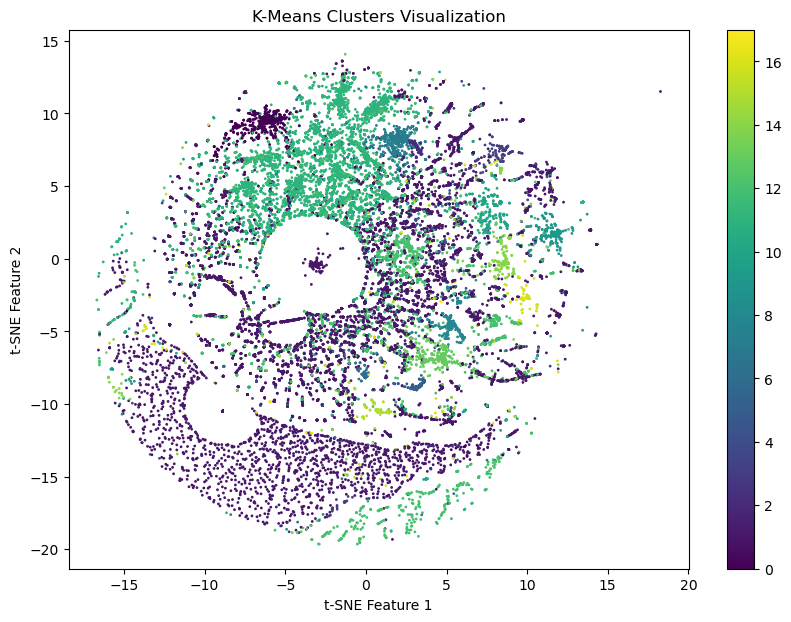

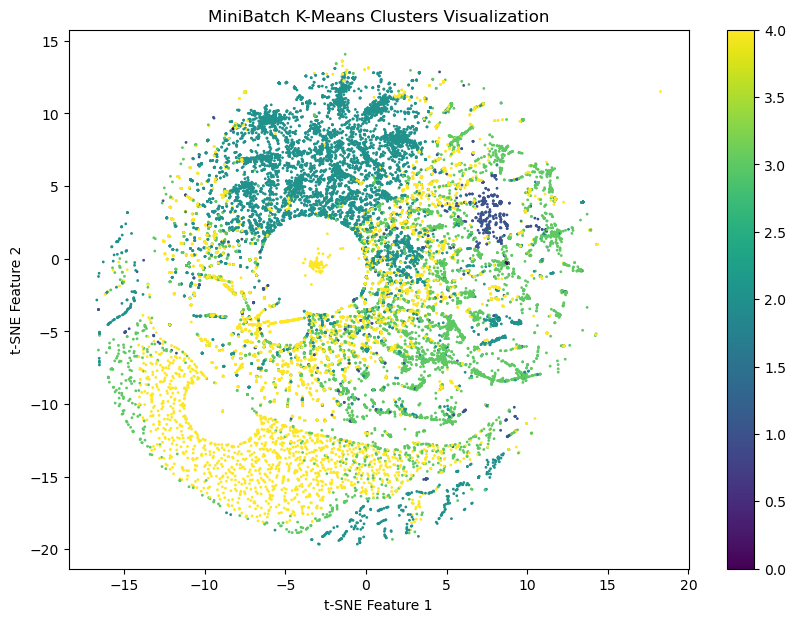

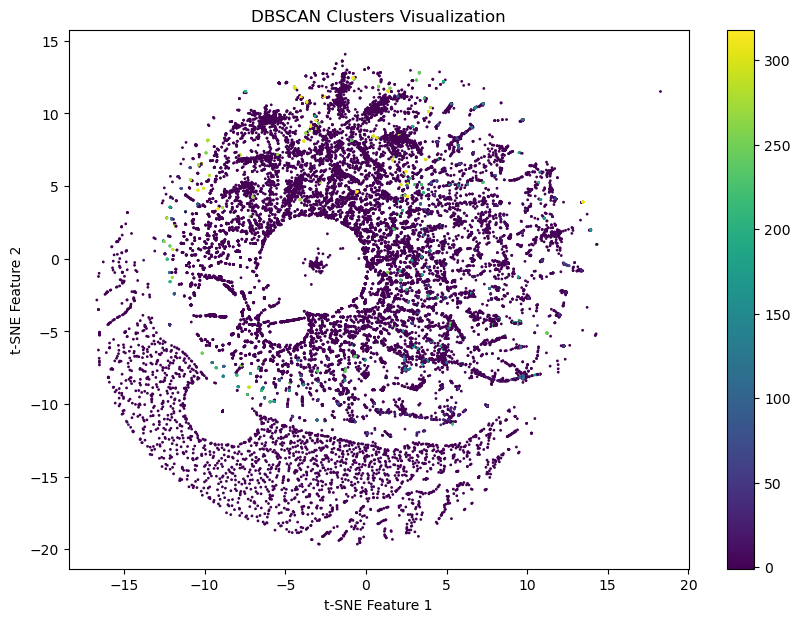

In [47]:
from sklearn.manifold import TSNE

# Use t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=50, n_iter=300, random_state=42)
X_tsne = tsne.fit_transform(X_norm.toarray())

# Plot the t-SNE reduced data for each clustering algorithm
def plot_clusters(X_reduced, labels, title):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='viridis', s=1)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.show()

# K-Means Clusters
plot_clusters(X_tsne, df['Cluster_KMeans'], 'K-Means Clusters Visualization')

# MiniBatch K-Means Clusters
plot_clusters(X_tsne, df['Cluster_MiniBatchKMeans'], 'MiniBatch K-Means Clusters Visualization')

# DBSCAN Clusters
plot_clusters(X_tsne, df['Cluster_DBSCAN'], 'DBSCAN Clusters Visualization')


In [57]:
# Aggregate keywords by cluster label for each algorithm and display a representative sample of keywords
def aggregate_keywords_by_cluster(df, cluster_column):
    # Group by the cluster label and aggregate keywords
    aggregated = df.groupby(cluster_column)['keywords_str'].apply(lambda x: ' '.join(x)).reset_index()
    
    # Take a sample of keywords for each cluster to make genre assignment manageable
    aggregated['sample_keywords'] = aggregated['keywords_str'].apply(lambda x: ' '.join(pd.Series(x.split()).unique()[:10]))
    
    return aggregated[[cluster_column, 'sample_keywords']]

# Apply the function to each cluster column
kmeans_keywords = aggregate_keywords_by_cluster(df, 'Cluster_KMeans')
minibatch_keywords = aggregate_keywords_by_cluster(df, 'Cluster_MiniBatchKMeans')
dbscan_keywords = aggregate_keywords_by_cluster(df, 'Cluster_DBSCAN')

# Saving the results to CSV files
kmeans_keywords.to_csv('kmeans_cluster_keywords.csv', index=False)
minibatch_keywords.to_csv('minibatch_kmeans_cluster_keywords.csv', index=False)
dbscan_keywords.to_csv('dbscan_cluster_keywords.csv', index=False)

# Display the results
print("K-Means Cluster Keywords:")
print(kmeans_keywords)
print("\nMiniBatch K-Means Cluster Keywords:")
print(minibatch_keywords)
print("\nDBSCAN Cluster Keywords:")
print(dbscan_keywords)

K-Means Cluster Keywords:
    Cluster_KMeans                                    sample_keywords
0                0  MATLAB TAA 2017 # 7 Programming with Visual St...
1                1  Go Kent Beck Extreme Programming Mike Meyers N...
2                2  2019 Kevin Wilson # Visual Studio 8.0 A+ 220-1...
3                3  today NoSQL Today API HTTP quarterly Amazon Re...
4                4  WebAssembly Learn GUI 2023 Content Management ...
5                5  Excel Microsoft Felix Zumstein 2019 Covers Wor...
6                6  more than 85 second Stephen Cleary Vim 120 300...
7                7  six 2019 Certified Cloud Security Professional...
8                8  Microsoft Exam Windows Server Infrastructure J...
9                9  Java FP Streams 21 Marc Loy Patrick Niemeyer D...
10              10  first Python Data Science Handbook Matplotlib ...
11              11  21 on&nbsp;a the 5th International Conference ...
12              12  the past decade JavaScript seventh ECMAScrip